In [1]:
import os
import sys
import shutil
import numpy as np
import pandas as pd

import tensorflow as tf


import itertools
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out UserWarning from specific module
warnings.filterwarnings("ignore", message="`layer.apply` is deprecated", category=UserWarning)


#tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.evaluation.python_evaluation import (map, ndcg_at_k, precision_at_k, recall_at_k)
from recommenders.utils.constants import SEED as DEFAULT_SEED
#from recommenders.utils.notebook_utils import store_metadata

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

from sklearn.model_selection import train_test_split

System version: 3.9.5 (tags/v3.9.5:0a7dcbd, May  3 2021, 17:27:52) [MSC v.1928 64 bit (AMD64)]
Pandas version: 1.5.3
Tensorflow version: 2.7.4


### 2. Setting Up Parameters

In [2]:
# top k items to recommend
TOP_K = 10

# Select  data size: 100k, 1m, 10m, or 20m
DATA_SIZE = 10000

# Model parameters
EPOCHS = 100 # ! Changed from 100 because it was taking forever
BATCH_SIZE = 256

SEED = DEFAULT_SEED  # Set None for non-deterministic results

### 3. Loading Dataframe


In [3]:
# * Load & Set Up Dataframe
original_dataframe = pd.read_csv('spotify_songs.csv')
CF_DF = original_dataframe

In [4]:
# Create Random Input Playlist of 10 Songs
input_samples = CF_DF.sample(n=10)
input_samples.to_csv('input.csv', index=False)

In [5]:
# Adding InputPlaylist to Dataframe
inputPlaylist = pd.read_csv('input.csv')
inputPlaylist['playlist_id'] = 'input_playlist'
inputPlaylist['playlist_name'] = 'input_playlist'

CF_DF = pd.concat([CF_DF, inputPlaylist], ignore_index=True)
df = CF_DF[['playlist_id', 'track_id']]

df.tail(10)

,playlist_id,track_id
32833,input_playlist,59s0s39NFWScuHDbHytI14
32834,input_playlist,1TT9cxHxX2C2F4g6oiwBLI
32835,input_playlist,5UEmKZKhsC9SizDy7xn2lT
32836,input_playlist,10qlTaZXfdAkUfsp5dcpcd
32837,input_playlist,3LbtSM3RFD0mLCoQlO43Xy
32838,input_playlist,34aycmeaxuuxipebrdkLUP
32839,input_playlist,4zXvB4MoQD8onk0NCZbeHG
32840,input_playlist,7oEKbx2bH88Mkcurwo0pfR
32841,input_playlist,4q2RJH99DFckparlsfCpBc
32842,input_playlist,4I1zD6WvoJoLDFWsqcCpMJ


In [6]:
# Create a DataFrame with all possible combinations of playlist_id and track_id
unique_playlists = df['playlist_id'].unique()
unique_tracks = df['track_id'].unique()

# Create a dataframe to store all combinations of playlist and track
all_combinations = pd.DataFrame([(playlist_id, track_id) for playlist_id in unique_playlists for track_id in unique_tracks],columns=['playlist_id', 'track_id'])
df = df.assign(rating=1)

# Merge with the original dataframe to check for existence
merged_df = all_combinations.merge(df, on=['playlist_id', 'track_id'], how='left')
#merged_df.drop_duplicates(subset=['playlist_id', 'track_id'], keep='first', inplace=True, ignore_index=True)

# Replace NaN values with 0 to represent absence of track in playlist
merged_df['rating'] = merged_df['rating'].fillna(0).astype(int)

# Select relevant columns
used_df = merged_df.loc[:, ['playlist_id', 'track_id', 'rating']]

# Filter out entries with playlist_id equal to 'input_user'
reg_df = used_df[used_df['playlist_id'] != 'input_playlist']
input_user_df = used_df[used_df['playlist_id'] == 'input_playlist']
input_user_df = input_user_df.sample(n=1000)
input_length = len(input_user_df)

# Step 2: Sample 10,000 - len(input_playlist) rows from reg_df
num_samples = 10000 - input_length
sampled_df = reg_df.sample(n=num_samples, replace=False)

# Step 3: Add the rows with input_playlist back to reg_df
concatenated_df = pd.concat([sampled_df, input_user_df], ignore_index=True)


# Factorizing 
concatenated_df['userID'], og_playlist_id = pd.factorize(concatenated_df['playlist_id'])
concatenated_df['itemID'], og_item_id  = pd.factorize(concatenated_df['track_id'])

UI_DF = concatenated_df[['userID', 'itemID', 'rating']]

#UI_DF.head()
print(len(UI_DF))
UI_DF.tail(10)

10000


,userID,itemID,rating
9990,471,8443,0
9991,471,8444,0
9992,471,8445,0
9993,471,8446,0
9994,471,8447,0
9995,471,8448,0
9996,471,8449,0
9997,471,8450,0
9998,471,8451,0
9999,471,8452,0


In [7]:
#---USERS---#
# Get Playlist Numbers 
User_Num = concatenated_df[['userID', 'playlist_id']].copy()
User_Num.drop_duplicates(subset='userID', inplace=True)
print('User Reference Length: ', len(User_Num))

# Get Playlist Names 
User_Name = CF_DF[['playlist_id', 'playlist_name']].copy()
User_Name.drop_duplicates(subset='playlist_id', inplace=True)

# Merge Playlist Num & Names
User_Ref = User_Num.merge(User_Name, how = 'left')
print('User Reference Length After Merge: ', len(User_Ref))

#---ITEMS---#
# Get Item Numbers
Item_Num = concatenated_df[['itemID', 'track_id']].copy()
Item_Num.drop_duplicates(subset='itemID', inplace=True)
print('Item Reference Length: ',len(Item_Num))

# Get Item Name & Artist
Item_Name_Artist = CF_DF[['track_id', 'track_name', 'track_artist']].copy()
Item_Name_Artist.drop_duplicates(subset='track_id', inplace=True)

# Merge Item Num & Names/Artists
Item_Ref = Item_Num.merge(Item_Name_Artist, how = 'left')
print('Item Reference Length After Merge: ',len(Item_Ref))


User Reference Length:  472
User Reference Length After Merge:  472
Item Reference Length:  8453
Item Reference Length After Merge:  8453


### 4. Training & Testing Split

In [8]:
#train, test = python_chrono_split(CF_DF, 0.75)
train, test = train_test_split(UI_DF, test_size=0.25, random_state=SEED)

In [9]:
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]

In [10]:
leave_one_out_test = test.groupby("userID").last().reset_index()

In [11]:
train_file = "./splits/train2.csv"
test_file = "./splits/test2.csv"
leave_one_out_test_file = "./splits/leave_one_out_test2.csv"
train = train.sort_values(by='userID')
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)

In [12]:
leave_one_out_test.to_csv(leave_one_out_test_file, index=False)

### 5. NCF Dataset 

In [13]:
data = NCFDataset(train_file=train_file, test_file=leave_one_out_test_file, seed=SEED, overwrite_test_file_full=True)

INFO:recommenders.models.ncf.dataset:Indexing ./splits/train2.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ./splits/leave_one_out_test2.csv ...
INFO:recommenders.models.ncf.dataset:Creating full leave-one-out test file ./splits/leave_one_out_test2_full.csv ...
100%|██████████| 309/309 [00:00<00:00, 310.75it/s]
INFO:recommenders.models.ncf.dataset:Indexing ./splits/leave_one_out_test2_full.csv ...


### 6. Non-Pre Trained

In [14]:
fact_results = []
input_recs = []

for Factor_Num in range(0,13):
    
    print(f'######################### Factor Num: {Factor_Num} #########################################')

    fact_result_row = []

    # add epoch number
    fact_result_row.append(Factor_Num)

    print('---TRAIN---')
    model = NCF(
            n_users=data.n_users, 
            n_items=data.n_items,
            model_type="NeuMF",
            n_factors=Factor_Num,
            layer_sizes=[16,8,4],
            n_epochs= 100,
            batch_size=BATCH_SIZE,
            learning_rate=1e-3,
            verbose=10,
            seed=SEED
        )

    with Timer() as train_time:
            model.fit(data)
            
    print("Took {} seconds for training.".format(train_time.interval))

    print(' ')

    print(' ')

    print('--- PREDICTIONS ---')

    predictions = [[row.userID, row.itemID, model.predict(row.userID, row.itemID)]
            for (_, row) in test.iterrows()]

    predictions = pd.DataFrame(predictions, columns=['userID', 'itemID', 'prediction'])

    # Group predictions by userID and rank remaining items based on predicted scores
    top_k_recs = predictions.groupby('userID').apply(lambda x: x.nlargest(TOP_K, 'prediction')).reset_index(drop=True)

    print('--- PREDICTIONS FOR INPUT USER ---')
    input_user_id = (len(User_Ref)) - 1 
    top_k_user = top_k_recs[(top_k_recs['userID'] == input_user_id)]

    row = User_Ref.loc[(User_Ref['userID'] == input_user_id)]

    item_list = top_k_user['itemID'].values

    input_rec_row = []
    input_rec_row.append(Factor_Num)
    
    i = 1
    print('Top 10 Recommendations For You:\n')
    for item in item_list:
        rec_info = []
        row = Item_Ref.loc[(Item_Ref['itemID'] == item)]

        name = row['track_name'].values[0]
        artist = row['track_artist'].values[0]
        
        rec_info.append(name)
        rec_info.append(artist)
        input_rec_row.append(rec_info)

        print(f"{i}.'{name}' - {artist}")
        i += 1
    
    input_recs.append(input_rec_row)

    print(' ')

    print('--- GENERIC EVALUATION ---')
    with Timer() as test_time:
        users, items, preds = [], [], []
        item = list(train.itemID.unique())
        for user in train.userID.unique():
            user = [user] * len(item) 
            users.extend(user)
            items.extend(item)
            preds.extend(list(model.predict(user, item, is_list=True)))

        all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

        merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
        all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

    print("Took {} seconds for prediction.".format(test_time.interval))

    eval_map = map(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

    print("MAP:\t%f" % eval_map,
        "NDCG:\t%f" % eval_ndcg,
        "Precision@K:\t%f" % eval_precision,
        "Recall@K:\t%f" % eval_recall, sep='\n')

    fact_result_row.append(eval_map)
    fact_result_row.append(eval_ndcg)
    fact_result_row.append(eval_precision)
    fact_result_row.append(eval_recall)

    print(' ')

    print('--- LEAVE-ONE-OUT EVALUATION ---')
    k = TOP_K

    ndcgs = []
    hit_ratio = []

    for b in data.test_loader():
        user_input, item_input, labels = b
        output = model.predict(user_input, item_input, is_list=True)

        output = np.squeeze(output)
        rank = sum(output >= output[0])
        if rank <= k:
            ndcgs.append(1 / np.log(rank + 1))
            hit_ratio.append(1)
        else:
            ndcgs.append(0)
            hit_ratio.append(0)

    eval_ndcg = np.mean(ndcgs)
    eval_hr = np.mean(hit_ratio)

    print("HR:\t%f" % eval_hr)
    print("NDCG:\t%f" % eval_ndcg)

    fact_result_row.append(eval_ndcg)
    fact_result_row.append(eval_hr)

    print(' ')
      
    fact_results.append(fact_result_row)

    print(' ')
    print(' ')


l@K:	0.004854
 
--- LEAVE-ONE-OUT EVALUATION ---
HR:	0.000000
NDCG:	0.000000
 
 
 
######################### Factor Num: 1 #########################################
---TRAIN---
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.89s]: train_loss = 0.002196 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.86s]: train_loss = 0.000463 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [1.00s]: train_loss = 0.000157 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [1.06s]: train_loss = 0.000252 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.89s]: train_loss = 0.000290 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.86s]: train_loss = 0.000167 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.86s]: train_loss = 0.000104 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [1.02s]: train_loss = 0.000109 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.89s]: train_loss = 0.000182 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.9

### 7. Pre-Trained 

In [15]:
fact_results_pretrained = []
input_recs = []

for Factor_Num in range(0,13):

    print(f'############ Number of Factors: {Factor_Num} #########')

    fact_result_row = []

    print(' ')

    print('--- STORE MLP PARAMETER ---')
    model = NCF(
        n_users=data.n_users, 
        n_items=data.n_items,
        model_type="MLP",
        n_factors=Factor_Num,
        layer_sizes=[16,8,4],
        n_epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate=1e-3,
        verbose=10,
        seed=SEED
    )

    with Timer() as train_time:
        model.fit(data)

    print("Took {} seconds for training.".format(train_time.interval))

    model.save(dir_name=".pretrain_fact/MLP")

    print(' ')

    print('--- STORE GMF PARAMETER ---')
    model = NCF(
        n_users=data.n_users, 
        n_items=data.n_items,
        model_type="GMF",
        n_factors=Factor_Num,
        layer_sizes=[16,8,4],
        n_epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate=1e-3,
        verbose=10,
        seed=SEED
    )

    with Timer() as train_time:
        model.fit(data)

    print("Took {} seconds for training.".format(train_time.interval))

    model.save(dir_name=".pretrain_fact/GMF")

    with Timer() as train_time:
            model.fit(data)

    print("Took {} seconds for training.".format(train_time.interval))

    print(' ')

    print('--- GENERIC EVALUATION ---')
    with Timer() as test_time:

        users, items, preds = [], [], []
        item = list(train.itemID.unique())
        for user in train.userID.unique():
            user = [user] * len(item) 
            users.extend(user)
            items.extend(item)
            preds.extend(list(model.predict(user, item, is_list=True)))

        all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

        merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
        all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

    print("Took {} seconds for prediction.".format(test_time.interval))
    eval_map2 = map(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_ndcg2 = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_precision2 = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_recall2 = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

    print("MAP:\t%f" % eval_map2,
        "NDCG:\t%f" % eval_ndcg2,
        "Precision@K:\t%f" % eval_precision2,
        "Recall@K:\t%f" % eval_recall2, sep='\n')

    fact_result_row.append(eval_map2)
    fact_result_row.append(eval_ndcg2)
    fact_result_row.append(eval_precision2)
    fact_result_row.append(eval_recall2)

    fact_results_pretrained.append(fact_result_row)



 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [1.01s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.94s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [1.05s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.88s]: train_loss = 0.693147 
Took 91.66501190000054 seconds for training.
 
--- STORE GMF PARAMETER ---
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.92s]: train_loss = 0.027841 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.86s]: train_loss = 0.004034 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [1.02s]: train_loss = 0.001835 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.91s]: train_loss = 0.001315 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.84s]: train_loss = 0.001174 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.96s]: train_loss = 0.000988 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.78s]: t

### 8. Visualizations

In [16]:
header = ['Factor Count', 'GE MAP', 'GE NDCG', 'GE PrecK', 'GE RecK', 'LOO HR', 'LOO NDCG',]

filename = 'fact_results.csv'

with open(filename, 'w') as file:
    for header in header:
        file.write(str(header)+', ')
    file.write('\n')

    
    for row in fact_results:
        for x in row:
            file.write(str(x) + ', ')
        file.write('\n')

In [17]:
header = ['Factor Count', 'PTGE MAP', 'PTGE NDCG', 'PTGE PrecK', 'PTGE RecK']

filename = 'fact_results_pretrained.csv'

with open(filename, 'w') as file:
    for header in header:
        file.write(str(header)+', ')
    file.write('\n')

    
    for row in fact_results_pretrained:
        for x in row:
            file.write(str(x) + ', ')
        file.write('\n')

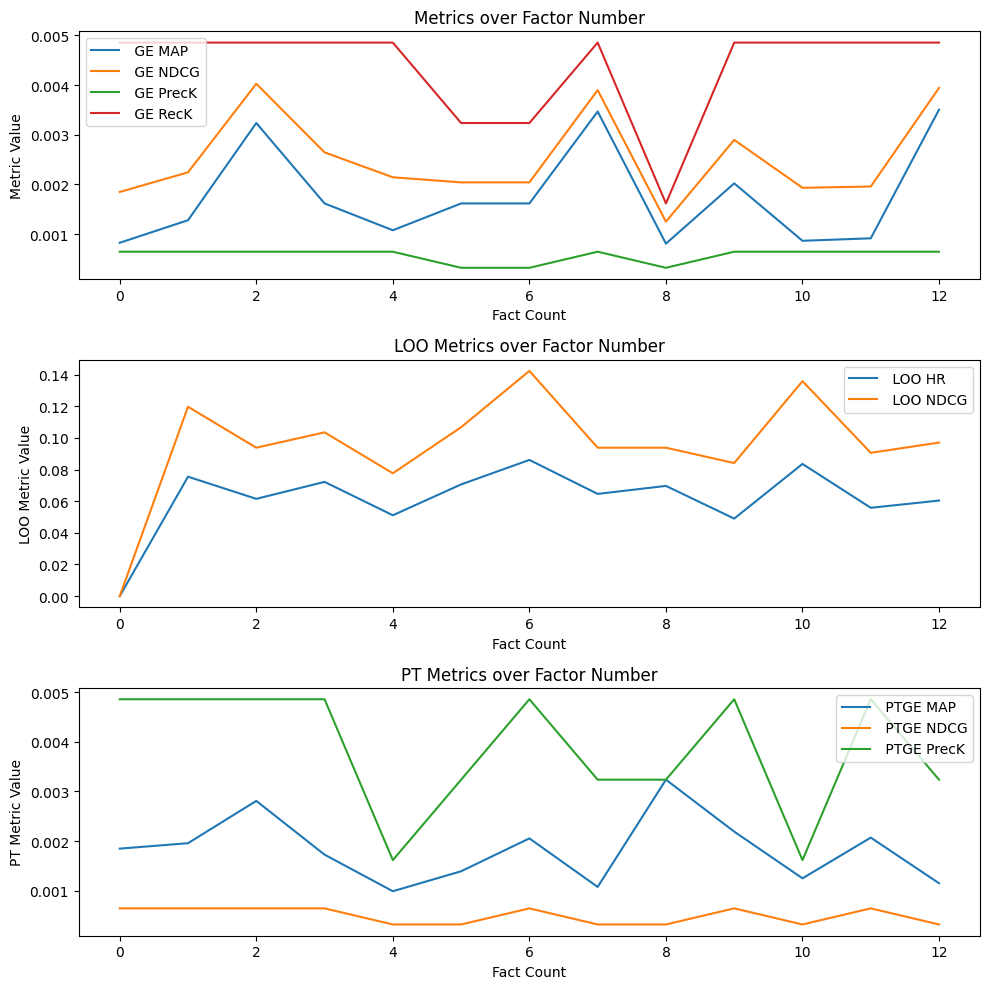

In [18]:
facts_df = pd.read_csv("fact_results.csv") 
pt_facts_df = pd.read_csv("fact_results_pretrained.csv") 


facts_df_rs = facts_df.reset_index()

# Set up the plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

# Plot using Seaborn lineplot
sns.lineplot(data=facts_df_rs[[' GE MAP',' GE NDCG',' GE PrecK',' GE RecK']], dashes=False, ax=axes[0])
axes[0].set_title('Metrics over Factor Number')
axes[0].set_xlabel('Fact Count')
axes[0].set_ylabel('Metric Value')
axes[0].legend()

# Plot using Seaborn lineplot
sns.lineplot(data=facts_df_rs[[' LOO HR', ' LOO NDCG']], dashes=False, ax=axes[1])
axes[1].set_title('LOO Metrics over Factor Number')
axes[1].set_xlabel('Fact Count')
axes[1].set_ylabel('LOO Metric Value')
axes[1].legend()


pt_facts_df_rs = pt_facts_df.reset_index()
# Plot using Seaborn lineplot
sns.lineplot(data=pt_facts_df[[' PTGE MAP', ' PTGE NDCG', ' PTGE PrecK', ' PTGE RecK']], dashes=False, ax=axes[2])
axes[2].set_title('PT Metrics over Factor Number')
axes[2].set_xlabel('Fact Count')
axes[2].set_ylabel('PT Metric Value')
axes[2].legend()


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()